In [1]:
import pandas as pd 
import numpy as np 
from PIL import Image as I
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import data
from skimage import filters
from skimage import exposure
from sklearn.cluster import KMeans as km 
import cv2

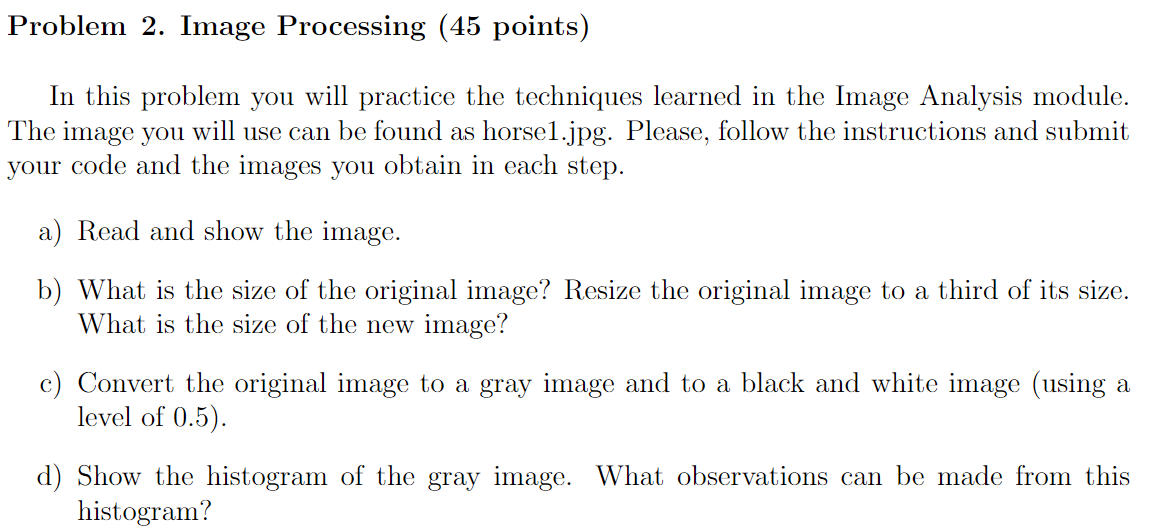
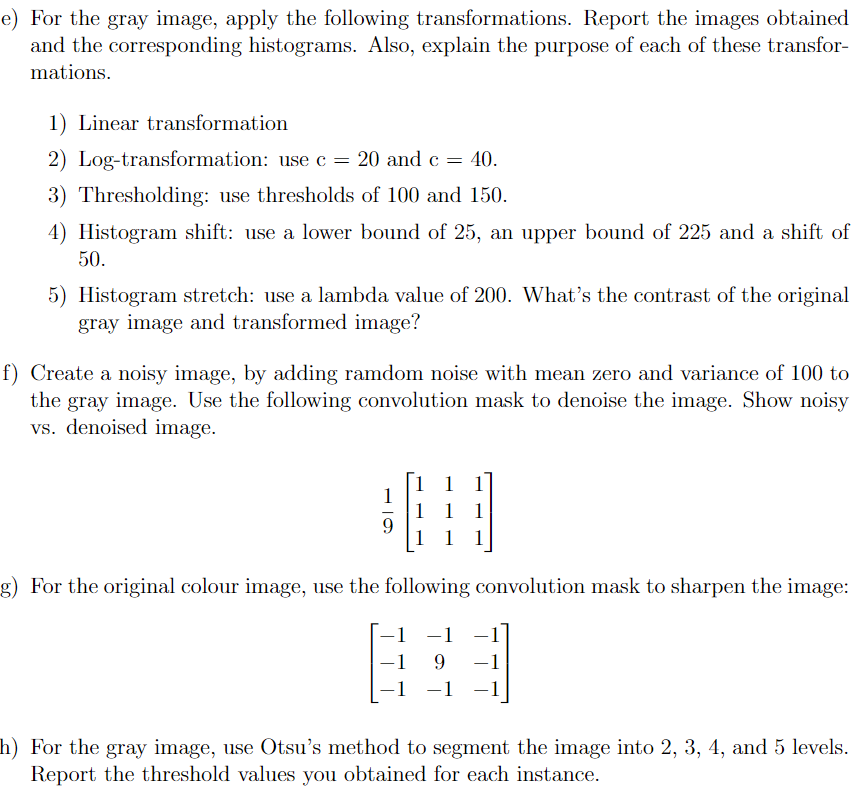
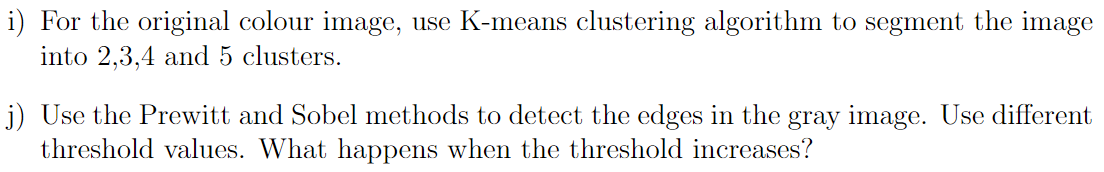

# Part A - Read & Show

To open and show the image, I will use the PIL package in Python, which loads it as an image object, and can be easily transformed into a numpy array. 

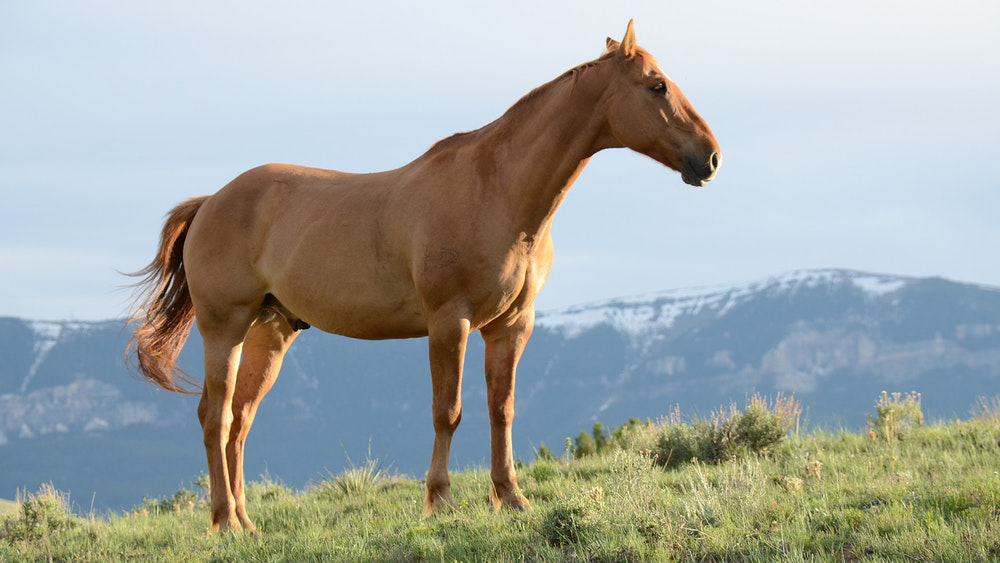

In [2]:
horse = I.open(r'../horse1-2.jpg')
df = np.array(horse)
horse

# Part B - Size

We can check the size of the image by simply using the .size method on the image object! 

In [3]:
horse.size

(1000, 563)

As can be seen, the image is 1000 pixels wide and 563 pixels long. 

Then, I can simply resize this using the resize method on the image object, and make it a third of its original size by simply passing in the original size divided by 3 (with no remainder). 

(333, 187)


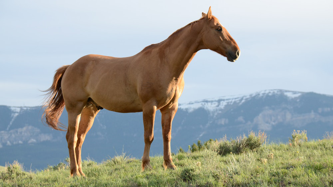

In [4]:
horse_small = horse.resize((horse.size[0]//3,horse.size[1]//3))
print(horse_small.size)
horse_small

The new size of this resized image is 333 pixels wide and 187 pixels long.

# Part C - Grey, Black & White

To turn the image into a grey image, there is a simple feature in PIL package that can be used on image objects. By calling .convert('L'), the images is transformed to a grey image.

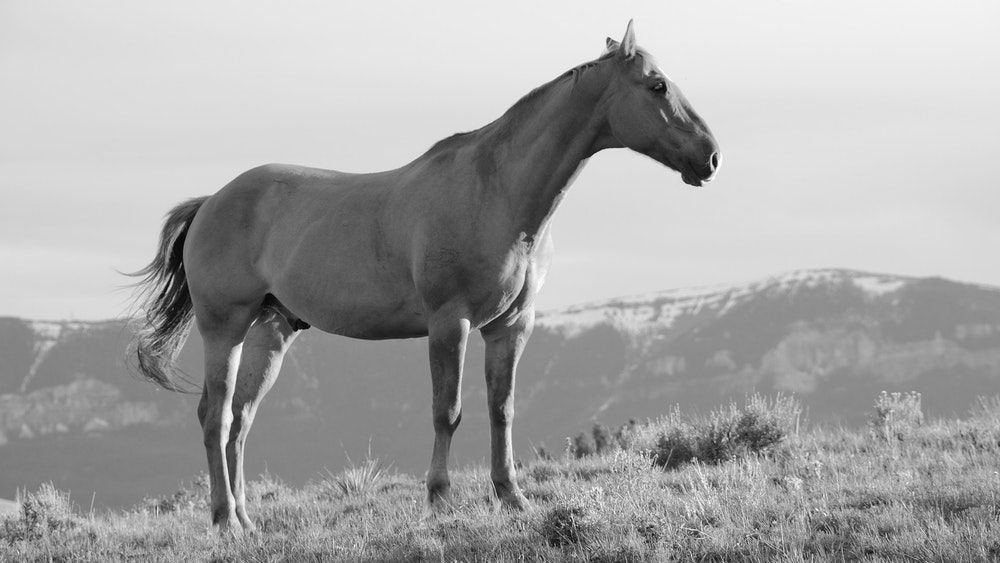

In [5]:
grey_horse = horse.convert('L')
df_grey = np.array(grey_horse)
grey_horse

Just for context, the process behind the scenes is the same as that done in Matlab, which I recreate in the function "rgb2gray" below. The red column values are multiplied by .2989, the green column values by 0.5870, and blue by .1140, to get the final values for our now 2D array (unlike the color array, which is 3D). 

Finally, note that, to perform operations on these arrays, we have to convert the data type first to integer (to perform the operations), and then back to "uint8" so that PIL can recognize it and display it correctly, hence the multiple ".astype()" functions in the rest of my code.

In [6]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3].astype(int), [0.2989, 0.5870, 0.1140]).astype('uint8')

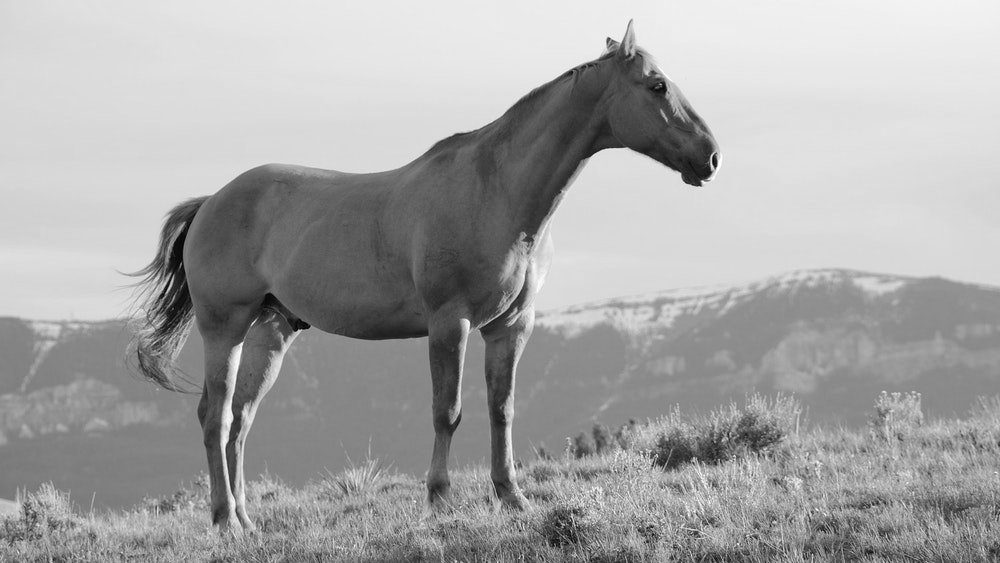

In [7]:
grey_horse_matlab = I.fromarray(rgb2gray(np.array(horse)))
grey_horse_matlab

Now, finally to make the image black and white with a 0.5 threshold, we can again use a simple method from PIL called .point() on the grey horse image. To get the 0.5 threshold, we simply take 50% of the shade values of the grey image to be white, and 50% of the values to be black. In other words, we can divide 256 by 2 (128), which serves as the cutoff point at which a pixel is decided to be black or white based on its value. If the pixel value is above threshold, it thus gets a value of 255 (the max shade value), otherwise 0.

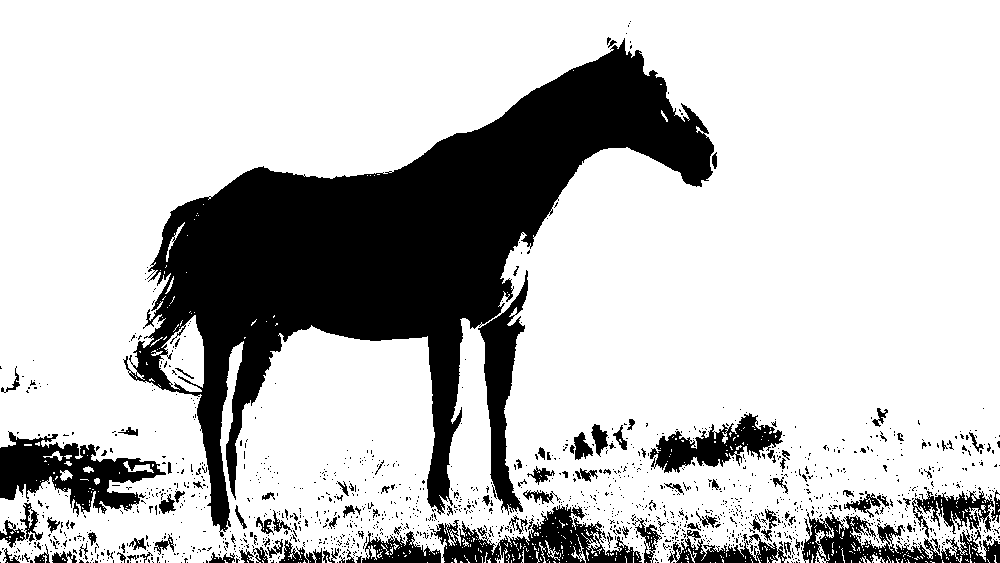

In [8]:
thresh = 256//2
fn = lambda x : 255 if x > thresh else 0
r = grey_horse.point(fn, mode='1')
r

# Part D - Histogram of Grey

We can visualize a histogram of the pixel values. To see the full distribution, I will use small bin sizes.

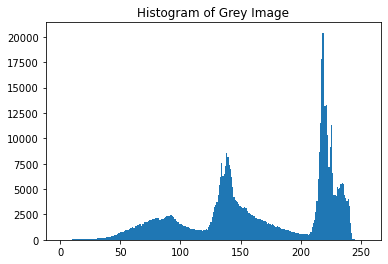

In [9]:
plt.hist(np.array(df_grey.astype(int)).flatten(),bins=np.arange(min(np.array(df_grey).flatten()), max(np.array(df_grey).flatten()) + 1, 1))
plt.title('Histogram of Grey Image')
plt.show()

As can be seen, looking at the distribution of the pixel values in the image, we can see that it is **tri-modal**, which very few truly black pixels, and a higher distribution toward the second-half of the spectrum (127 and up)!

# Part E - Transformation of Grey

## 1) Linear Transformation

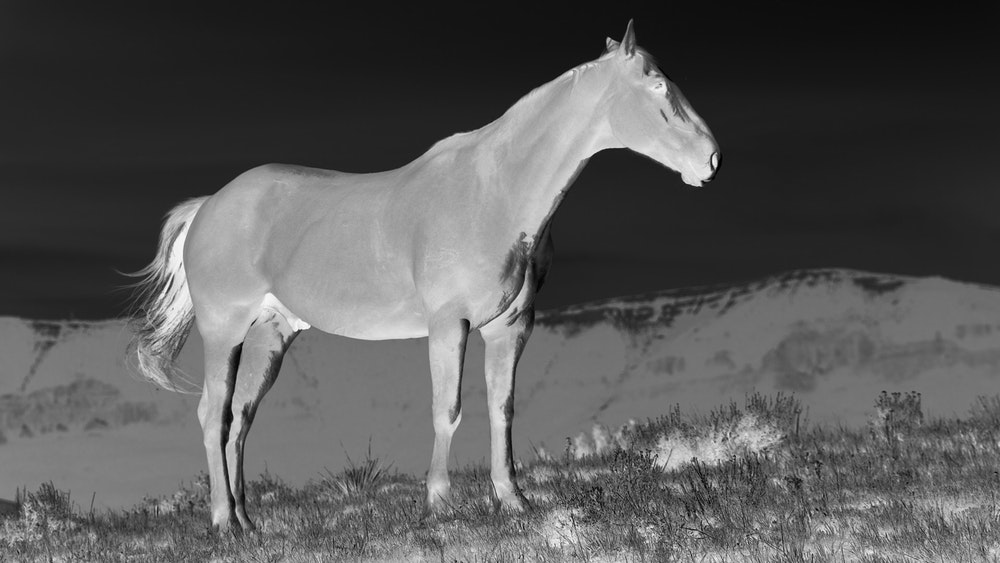

In [10]:
I.fromarray(((255-1) - df_grey.astype(int)).astype('uint8'))

**A linear transformation of an image turns it into a negative**. As can be seen, this is easily accomplished by (255-1) - the array of the greyscale image, as shown in lecture.

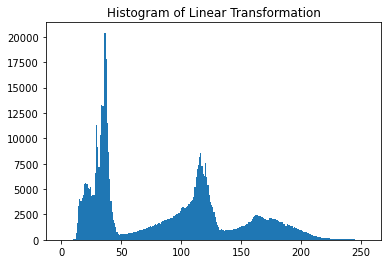

In [11]:
plt.hist(((255-1) - df_grey.astype(int)).flatten(),bins=np.arange(0,255,1))
plt.title('Histogram of Linear Transformation')
plt.show()

Notice how the transformation simply reflected the histogram across pixel values! The distribution is exactly the same shape, simply reflected, as expected.

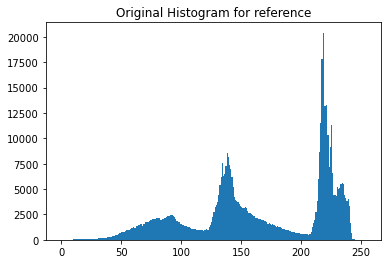

In [12]:
plt.hist((df_grey.astype(int)).flatten(),bins=np.arange(0,255,1))
plt.title('Original Histogram for reference')
plt.show()

## 2) Log Transformation: c = 20,40

Log transformations take the log of the pixel values of an image, and serve as a type of image enhancement. Because of the nature of log functions, this specifically **reduces the range of differences in the values, thereby squishing the histogram**, and specifically will have a much bigger change on values closer to 0, but this effect itself will be unnoticeable, as the values range from 0 all the way to 255, and thus would only matter for pixel values of 0 to 15. 

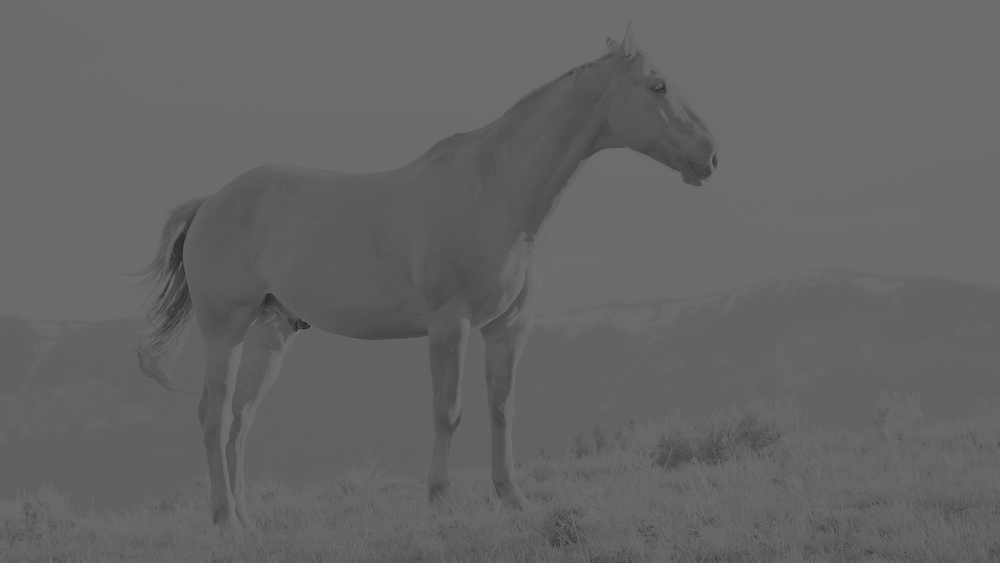

In [13]:
log_grey = (20*np.log(df_grey.astype(int)+1))
I.fromarray(log_grey.astype('uint8'))

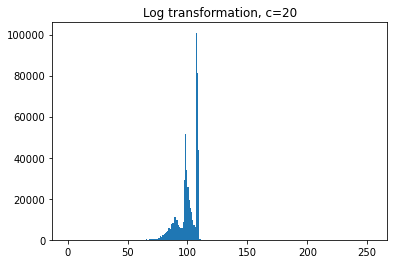

In [14]:
plt.hist(log_grey.astype(int).flatten(),bins=np.arange(0,255,1))
plt.title('Log transformation, c=20')
plt.show()

For a log transformation, again I simply use the equations given in lecture. The top image is with a c-value of 20, and the photo below with a c-value of 40. 

As can be seen, when we take a log transformation, the distribution is compressed, with more or less the same "shape" in terms of the three modal sections of the distribution.

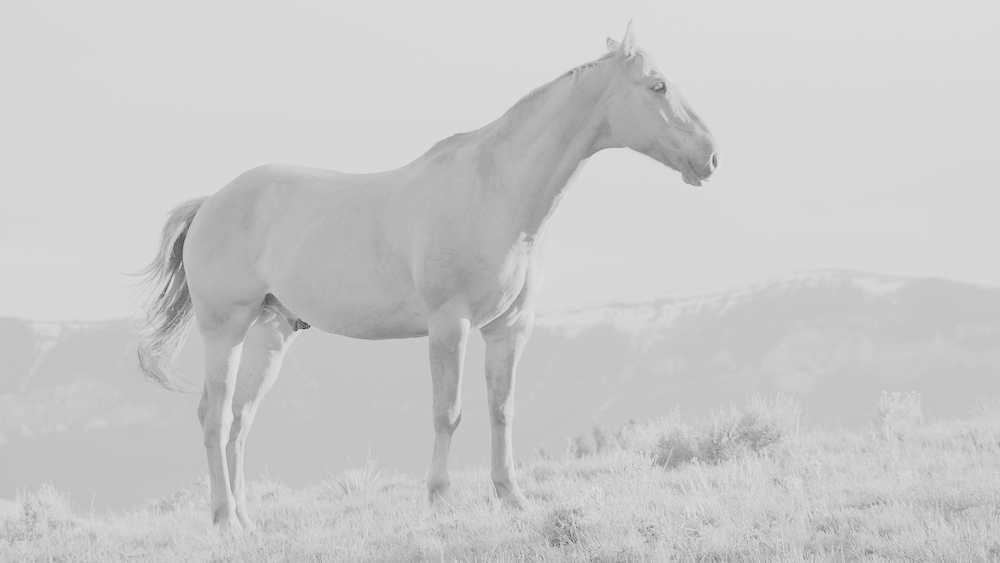

In [15]:
log_grey = (40*np.log(df_grey.astype(int)+1))
I.fromarray(log_grey.astype('uint8'))

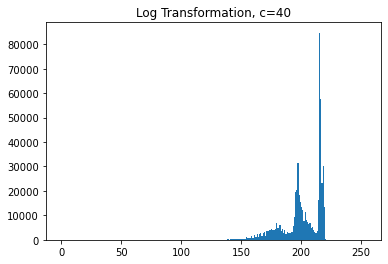

In [16]:
plt.hist(log_grey.astype(int).flatten(),bins=np.arange(0,255,1))
plt.title('Log Transformation, c=40')
plt.show()

Notice with a higher "c" value, of course the distribution shifts upward, as we are directly multiplying by C, but also the lower end of the distribution is is now wider than when we had a lower C-value. 

## 3) Thresholding: 100 & 150

Just like above, **I can use a treshold to turn the images into black and white,** with the value of the new pixels depending on the threshold value:

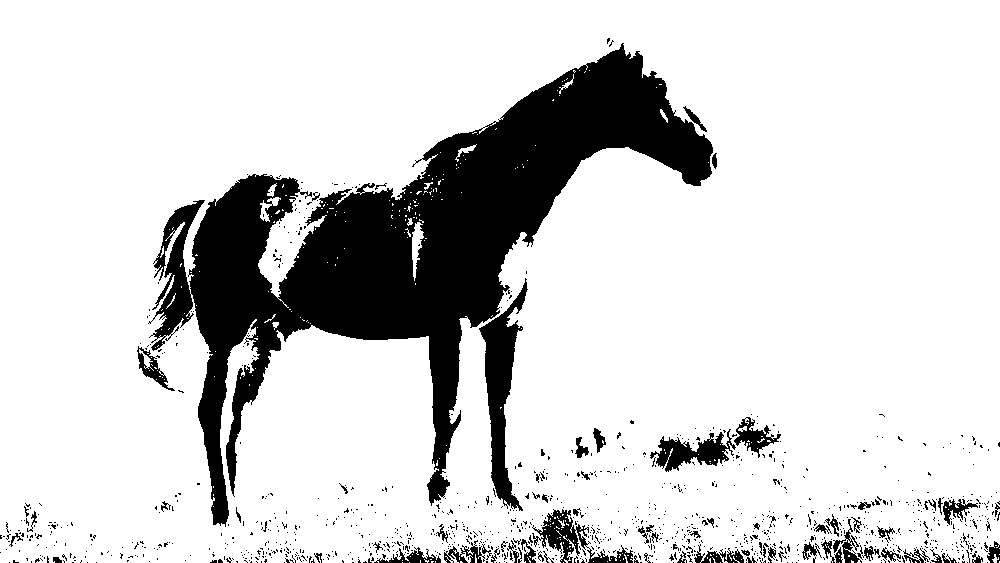

In [17]:
thresh = 100
fn = lambda x : 255 if x > thresh else 0
r100 = grey_horse.point(fn, mode='1')
r100

Text(0.5, 1.0, 'Thresholding: 100')

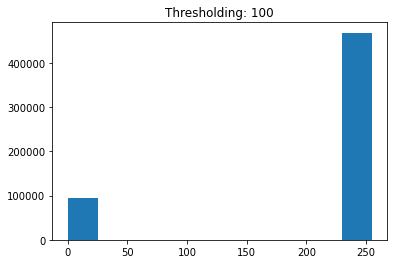

In [18]:
plt.hist(np.where(np.array(r100).flatten().astype(int)==1,255,0))
plt.title('Thresholding: 100')

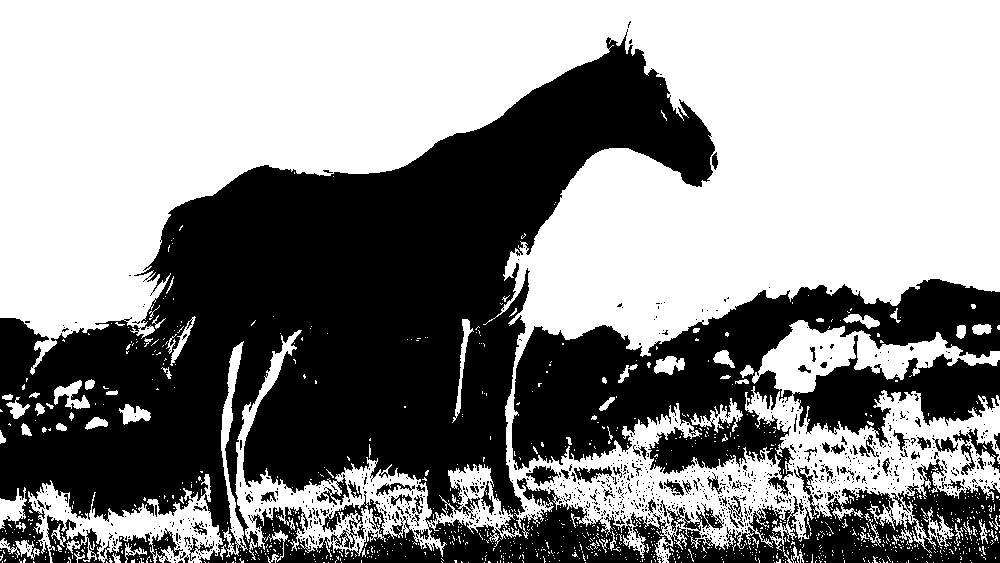

In [19]:
thresh = 150
fn = lambda x : 255 if x > thresh else 0
r150 = grey_horse.point(fn, mode='1')
r150

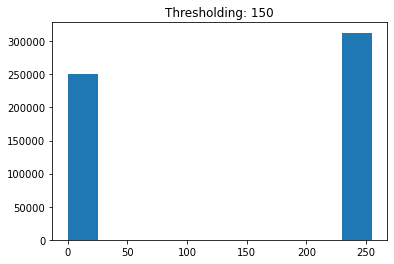

In [20]:
plt.hist(np.where(np.array(r150).flatten().astype(int)==1,255,0))
plt.title('Thresholding: 150')
plt.show()

As expected, when the threshold increases, more cells will be black (higher distribution of 0-value pixels).

## 4) Histogram Shift: L = 25, U = 225, Shift = 50

Histogram shifts simply shift the histogram as expected by a designated shade value, **thus lightening or darkening the image**. It's fairly simple, except that, since the pixel values of a grey image can only range from 0 to 255, if a shade + the shift passes 255, it must simply stay at a value of 255, and likewise, if the addition would cause the value to go below 0, it simply stays at a value of 0, hence the multiple lines in the function I create below.

Finally, in a shifting function, while I mention the min and max values of 0 and 255, these min and max values can be defined by the user in the function to limit the range of the histogram.

In [21]:
def shifter(arr,s,U=255,L=0):
    t = arr.astype(int)
    t = t+s
    t = np.where(t>U,U,t)
    t = np.where(t<=L,L,t)
    return t.astype('uint8')

Belo is the original image for reference:

Original Image for Reference!


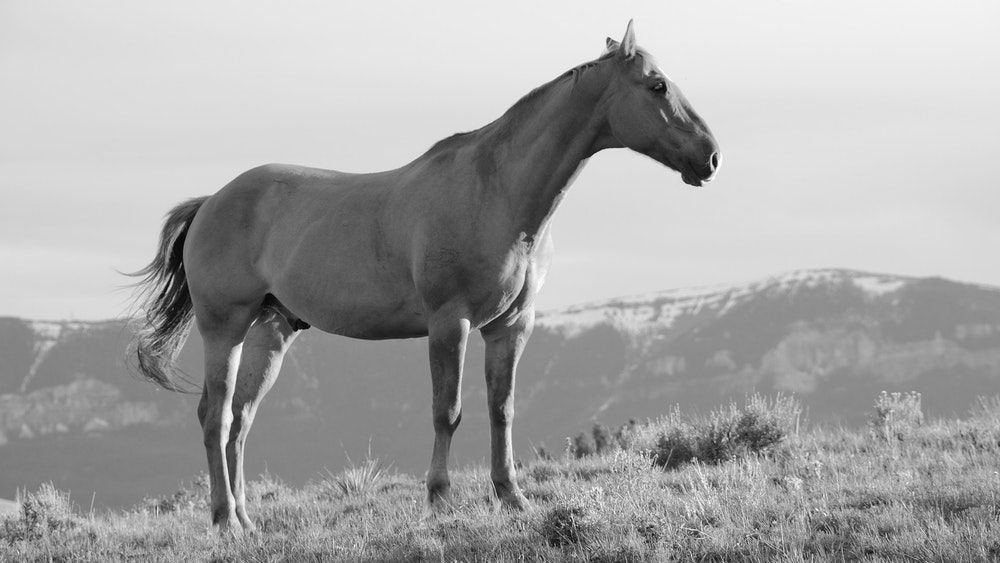

In [22]:
print('Original Image for Reference!')
grey_horse

Below is the image shifted by 50 (brighter), and limited to a low of 25 (not fully black), and a high of 225 (not fully white):

Shift of 50


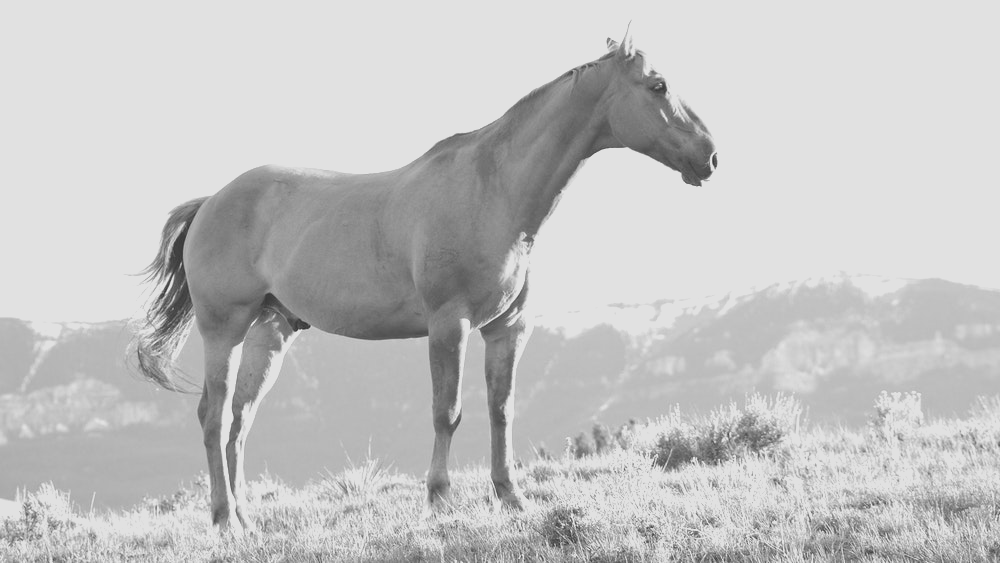

In [23]:
print("Shift of 50")
I.fromarray(shifter(df_grey,s=50,L=25,U=225))

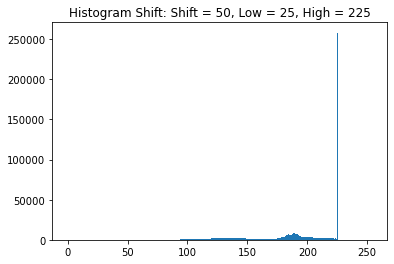

In [24]:
plt.hist(shifter(df_grey,s=50,L=25,U=225).flatten(),np.arange(0,255,1))
plt.title('Histogram Shift: Shift = 50, Low = 25, High = 225')
plt.show()

As can be seen, the histogram has a reallu high count of the upper limit value of 225. This is due to both the upper limit of the histogram being pushed down to 225 (which forces all values originally 225 or higher now to 255), and also the 50-value shift, pushing values 175 and up to 225. In summary, any pixel values of 175 to 255 now simply have a value of 225.

Shift of -50


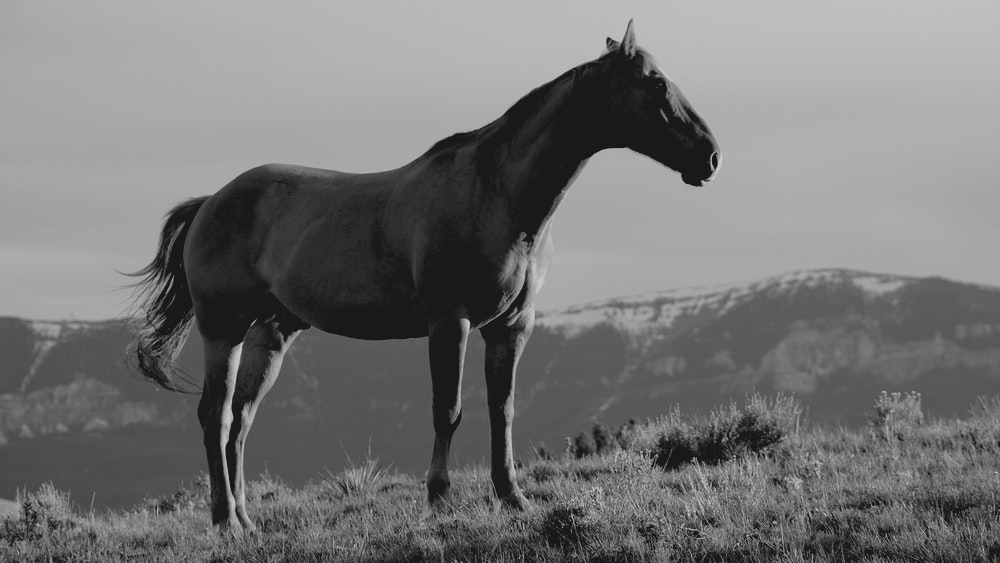

In [25]:
print("Shift of -50")
I.fromarray(shifter(df_grey,s=-50,L=25,U=225))

Text(0.5, 1.0, 'Histogram Shift: Shift = -50, Low = 25, High = 225')

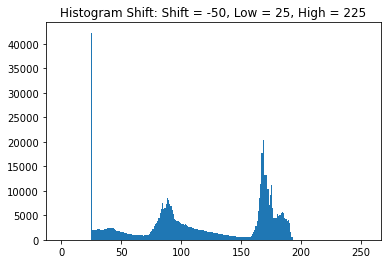

In [26]:
plt.hist(shifter(df_grey,s=-50,L=25,U=225).flatten(),np.arange(0,255,1))
plt.title('Histogram Shift: Shift = -50, Low = 25, High = 225')

Again, we see a spike of pixels with a value of the lower limit, 25, this time again due to the raised lower limit, and the negative shift. Now, any original pixels with a value of 0 to 75 will have a value of 25. 

## 5) Histogram Stretch: $\lambda$ = 200 

Histogram stretches **serve to add contrast to an image** by stretching the shade-value-distribution. Below I calculate the new shades with a stretch, show the histogram, and below it, plot the original photo with its original histogram:

Histogram Stretch: Lambda = 200


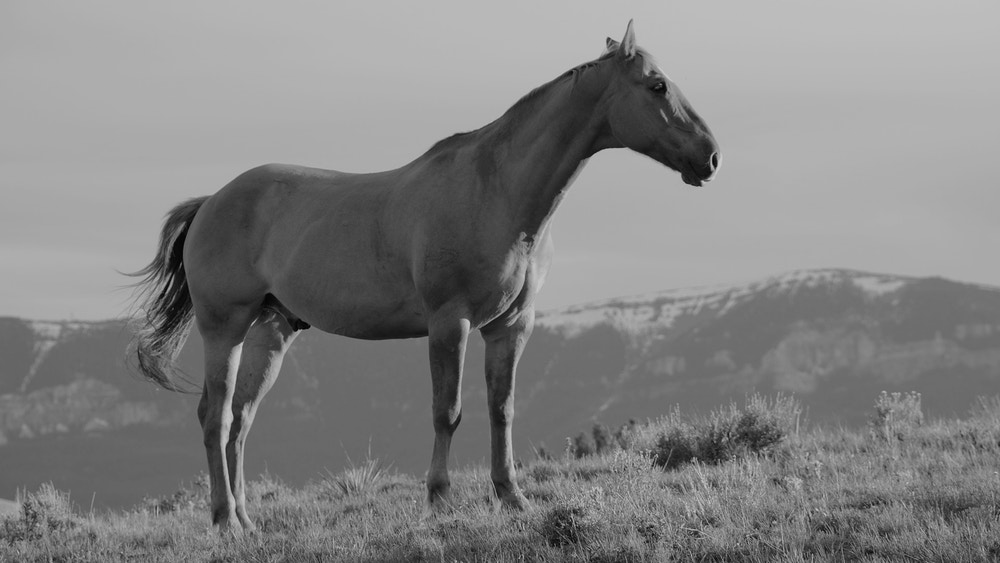

In [27]:
print("Histogram Stretch: Lambda = 200")
bins = np.arange(0, 256, 1, dtype=int)
Img1 = ((df_grey-np.min(df_grey))/(np.max(df_grey)-np.min(df_grey))*200)
I.fromarray(Img1.astype('uint8'))

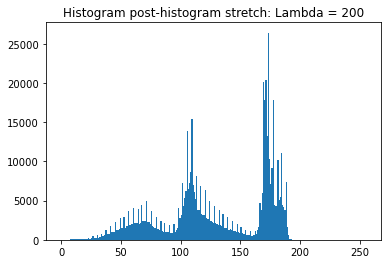

In [28]:
plt.figure()
b, bins, patches = plt.hist(Img1.ravel(), bins=bins)
plt.title('Histogram post-histogram stretch: Lambda = 200')
plt.show()

Original Grey Image


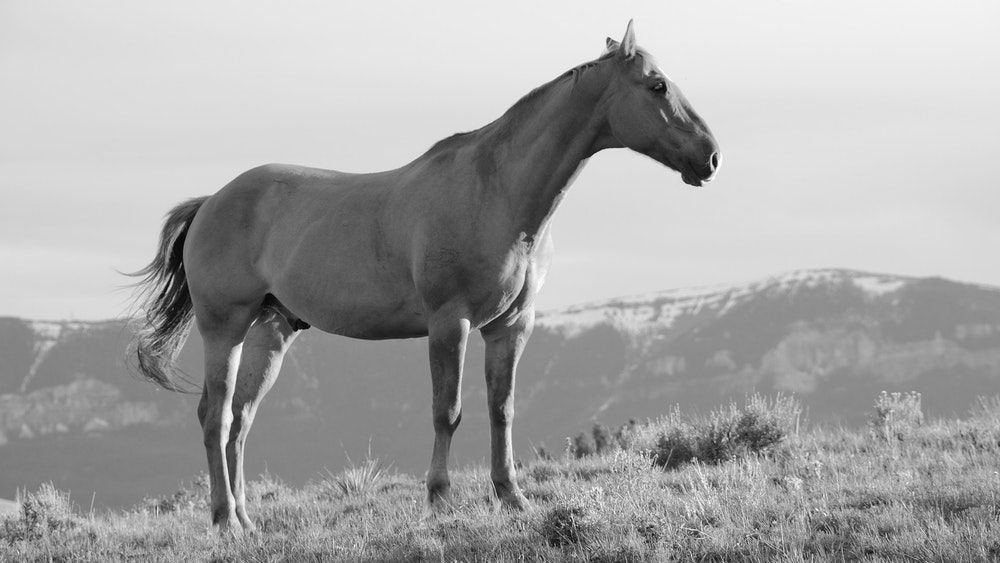

In [29]:
print("Original Grey Image")
grey_horse

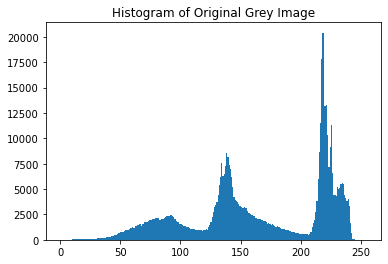

In [30]:
plt.hist(np.array(df_grey.astype(int)).flatten(),bins=np.arange(min(np.array(df_grey).flatten()), max(np.array(df_grey).flatten()) + 1, 1))
plt.title('Histogram of Original Grey Image')
plt.show()

# Part F - Noisy Image

First, as required by the question, I will add noise to the original image, with the noise having a variance of 100 (aka, standard deviation of 10). 

This noise is first created by generating random values from a gaussian distribution, and then added to the original image pixel-per-pixel.

In [31]:
size = df_grey.shape[0]*df_grey.shape[1]
noise = np.random.normal(0,10,size)
noise = noise.reshape((df_grey.shape[0],df_grey.shape[1]))

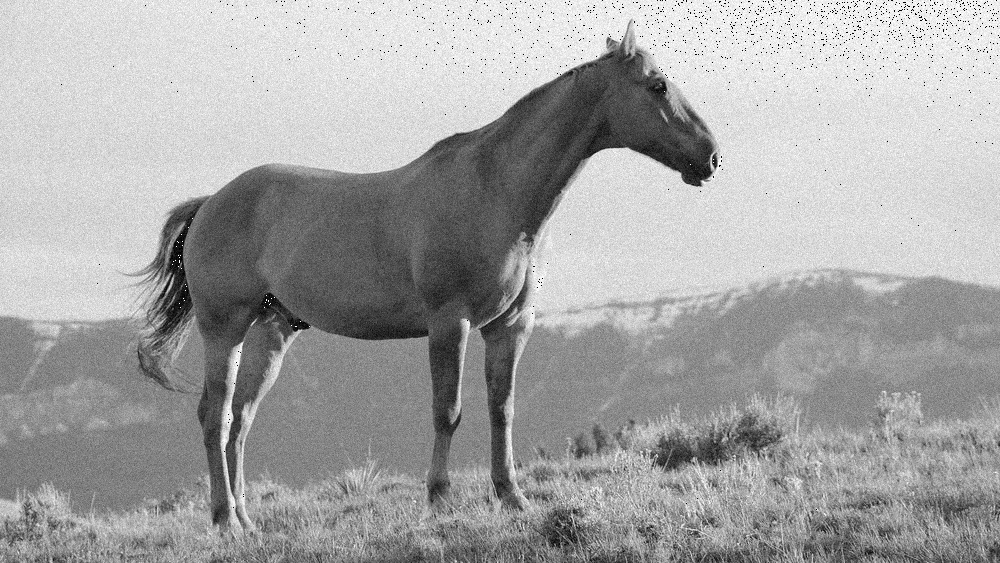

In [32]:
I.fromarray((df_grey.astype(int)+noise).astype('uint8'))

The noise definitely can be seen, especiallu in areas where the pixel values reach extreme values like 0 and 255 (noted in the black pixels in the sky). As we will now still transform the image with a convolution, I will not threshold these pixel values on the extremes just yet, as we will see that this problem goes away after blurring.

applying the kernel instructed below, we can see the now blurred image, in which the noise is now not so granular, but still adds patches of discoloration to the now somewhat blurry image.

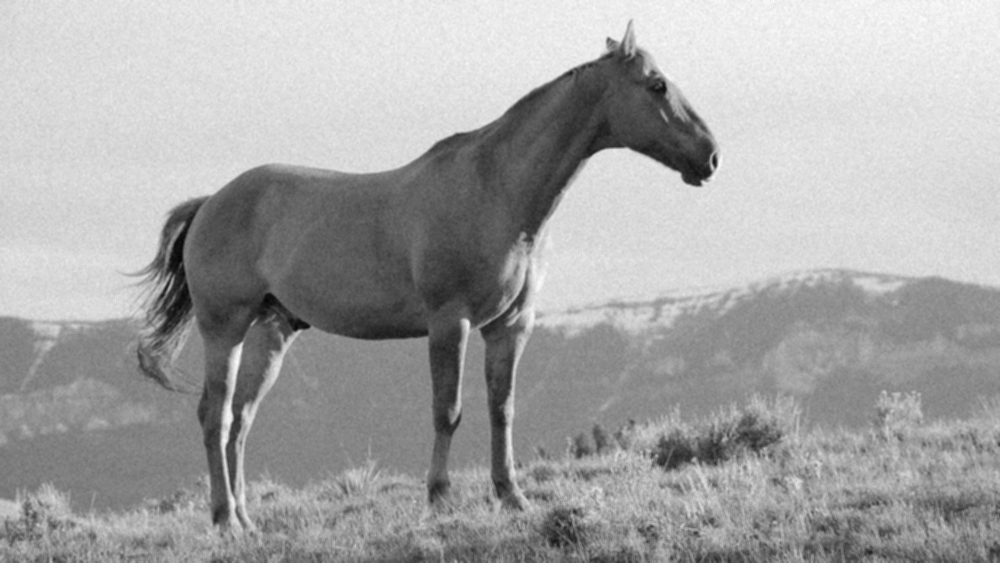

In [33]:
I.fromarray(cv2.filter2D(df_grey.astype(int)+noise,-1,(1/9)*np.array([[1,1,1],[1,1,1],[1,1,1]])).astype('uint8'))

# Part G - Sharpen Colored Image

Because we have to sharpen the color image, I must apply the sharpening convolution to each color individually. Below I create the kernel and do so:

In [34]:
kernel =np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
layer1 = cv2.filter2D(df[:,:,0],-1,kernel=kernel).astype(int)
layer2 = cv2.filter2D(df[:,:,1],-1,kernel=kernel).astype(int)
layer3 = cv2.filter2D(df[:,:,2],-1,kernel=kernel).astype(int)

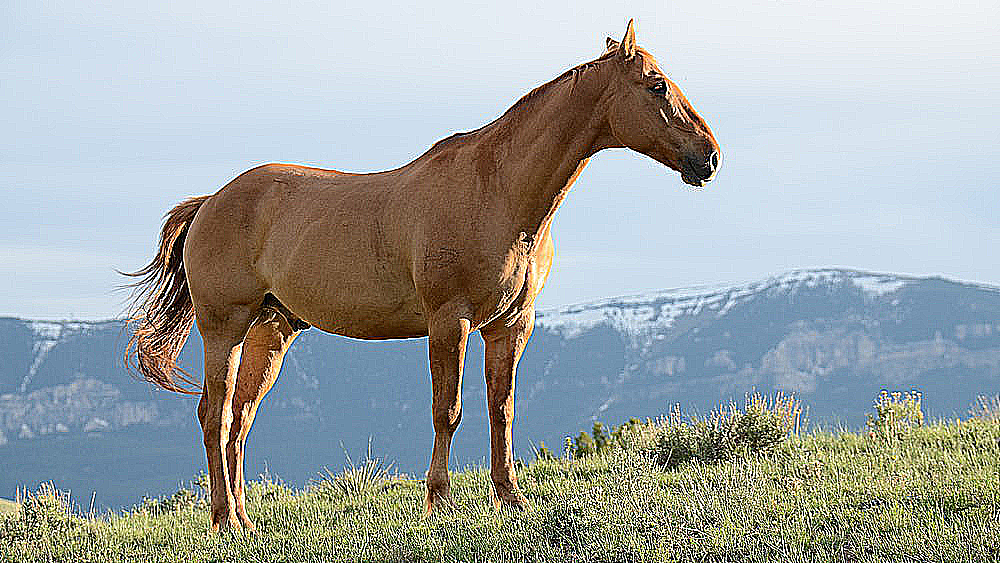

In [35]:
I.fromarray(np.dstack([layer1,layer2,layer3]).astype('uint8'))

As can be seen, the image is sharpened nicely, with some small, almost unnoticeable **chromatic aberration** along the belly of the horse, and its legs, most likely due to the abrupt change in color hues from the horse to the blue mountains and sky. The grass also shows slight signs of aberration, simply due to the already noisy texture of the grass, which was even further sharpened. 

# Part H - Otsu's Method

Otsu's method is a form of image segmentation, in which different ranges of the value of pixel shading are chosen to be grouped together. In other words, it's also a way to perform thresholding, in which the algorithm determines the optimal threshold by minimizing the intra-class variance (maximizing the inter-class variance). 

Otsu's can serve to segment the image in more than just two segments, which we will see below!

In [36]:
twolev = filters.threshold_multiotsu(df_grey.astype(int),classes=2)
threelev = filters.threshold_multiotsu(df_grey.astype(int),classes=3)
fourlev = filters.threshold_multiotsu(df_grey.astype(int),classes=4)
fivelev = filters.threshold_multiotsu(df_grey.astype(int),classes=5)

In [37]:
def multi_otsu(arr,levels):
    df = arr.copy().astype(int)
    n = len(levels)
    final_vals = []
    
    for i in range(n):
        final_vals.append((255//n)*i)
    final_vals.append(255)
    
    df = np.where(df<levels[0],final_vals[0],df)
    for i in range(1,n-1):
        df = np.where((df>=levels[i])&(df<levels[i+1]),final_vals[i],df)
    df = np.where(df>=levels[-1],final_vals[-1],df)
    return df.astype('uint8')

The optimal threshold found via Otsu's Method = [167]


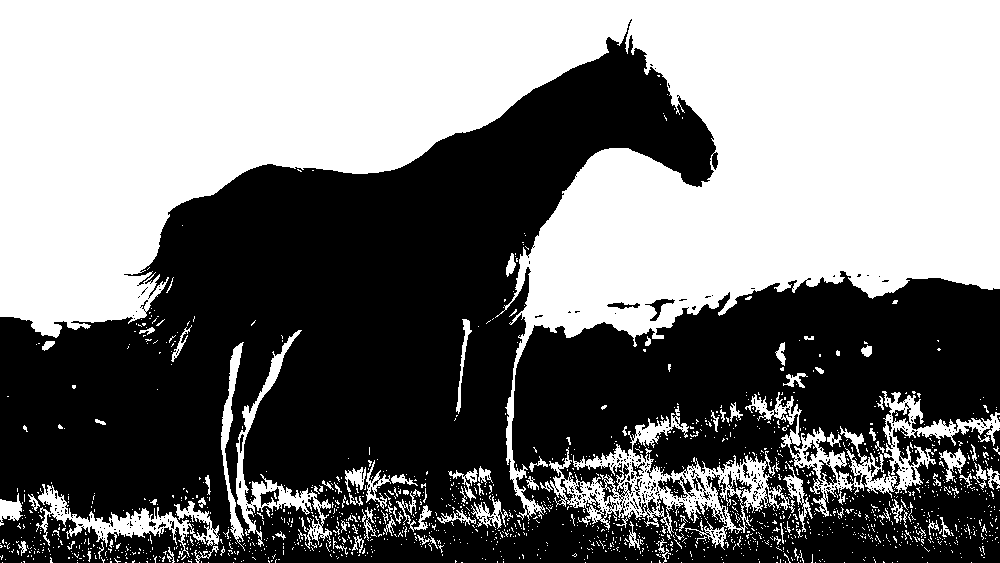

In [38]:
print(f"The optimal threshold found via Otsu's Method = {twolev}")
I.fromarray(multi_otsu(df_grey,twolev))

The optimal thresholds found via Otsu's Method = [112 183]


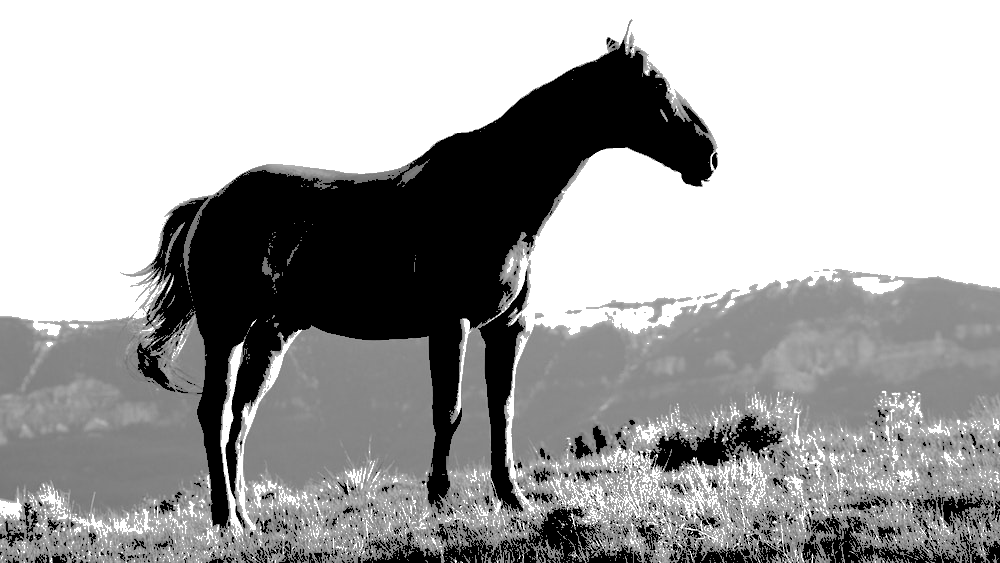

In [39]:
print(f"The optimal thresholds found via Otsu's Method = {threelev}")
I.fromarray(multi_otsu(df_grey,threelev))

As can be seen, with just three clusters or levels, the image looks very defined, and the threshold values maximize the details presented in the image. It looks quite great! 

The optimal thresholds found via Otsu's Method = [106 152 195]


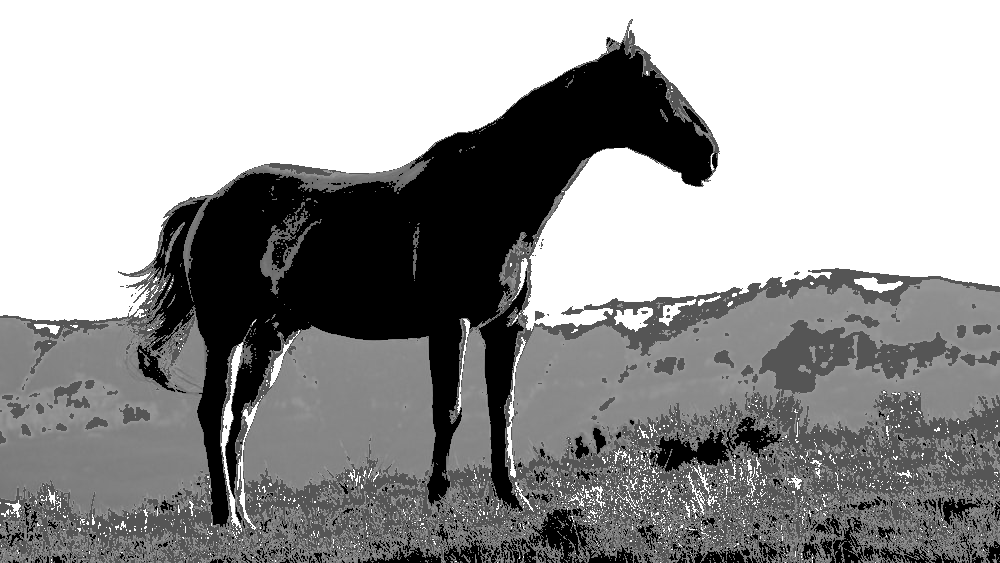

In [40]:
print(f"The optimal thresholds found via Otsu's Method = {fourlev}")
I.fromarray(multi_otsu(df_grey,fourlev))

The optimal thresholds found via Otsu's Method = [ 77 115 154 196]


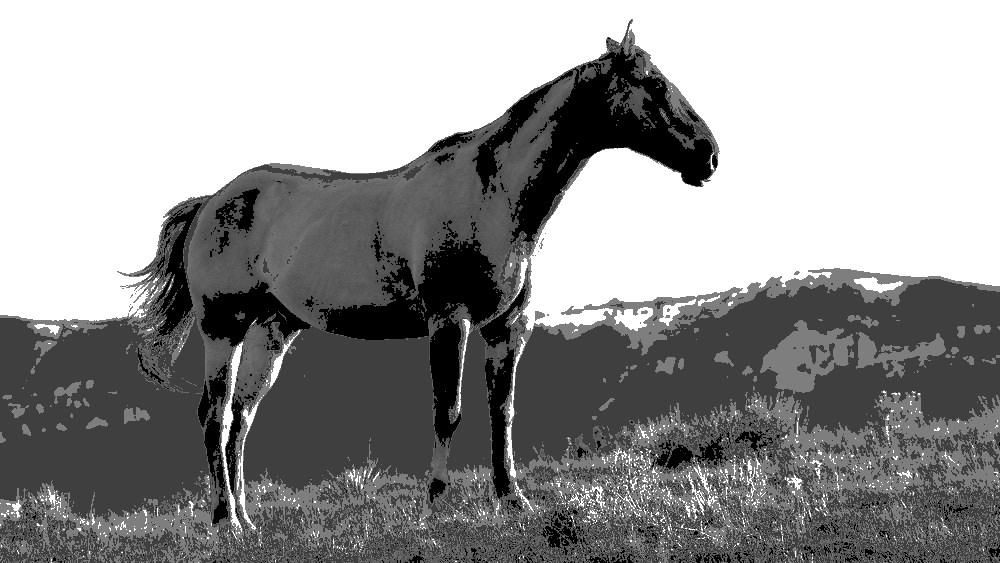

In [41]:
print(f"The optimal thresholds found via Otsu's Method = {fivelev}")
I.fromarray(multi_otsu(df_grey,fivelev))

# Part I - K-Means Segmentation

For this section, we must use kmeans clustering on the original color image. Thus, I will use sklearn's kmeans algorithm, and will use the RGB values of each cluster center to determine the color of the clustered pixels. 

In [42]:
def kmeaner(arr,clusters=2):
    kmeans = km(n_clusters=clusters)
    kmeans.fit(arr.reshape((arr.shape[0]*arr.shape[1],arr.shape[2])))
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    R_map = dict(zip(pd.Series(centers[:,0]).index, pd.Series(centers[:,0])))
    G_map = dict(zip(pd.Series(centers[:,0]).index, pd.Series(centers[:,1])))
    B_map = dict(zip(pd.Series(centers[:,0]).index, pd.Series(centers[:,2])))
    
    R = pd.Series(labels).map(R_map)
    G = pd.Series(labels).map(G_map)
    B = pd.Series(labels).map(B_map)
    c = np.concatenate((np.array(R).reshape(len(R),1),np.array(G).reshape(len(G),1),np.array(B).reshape(len(B),1)),axis=1)
    return c.reshape((arr.shape[0],arr.shape[1],arr.shape[2]))

2 clusters:


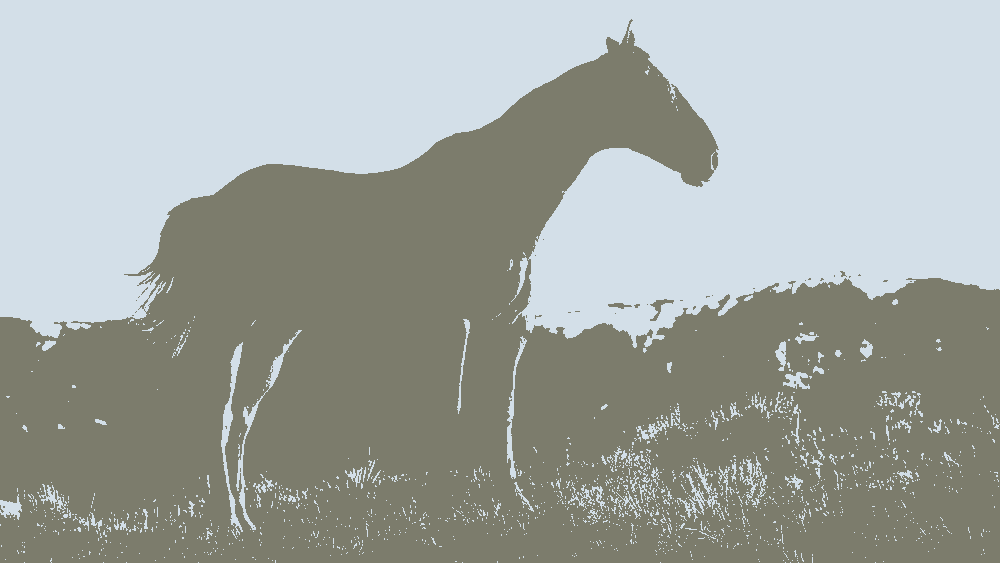

In [43]:
print("2 clusters:")
I.fromarray(kmeaner(df,clusters=2).astype('uint8'))

As can be seen, with just a few clusters, the colors are muddled and grey, as the cluster centers are averaging over so much variety of colors for all R, G,and B values of the pixels included in these relatively big clusters.

3 clusters


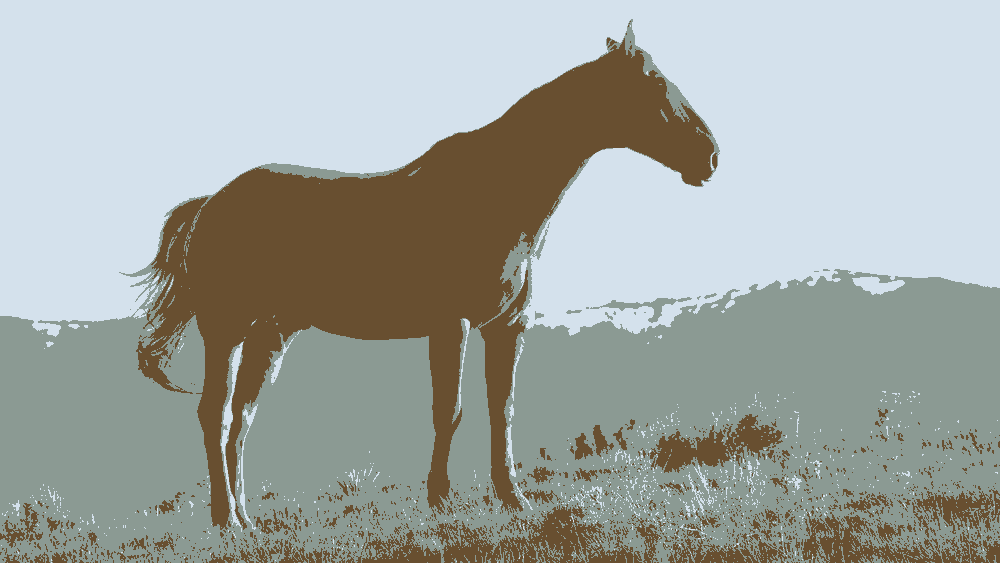

In [44]:
print("3 clusters")
I.fromarray(kmeaner(df,clusters=3).astype('uint8'))

4 clusters:


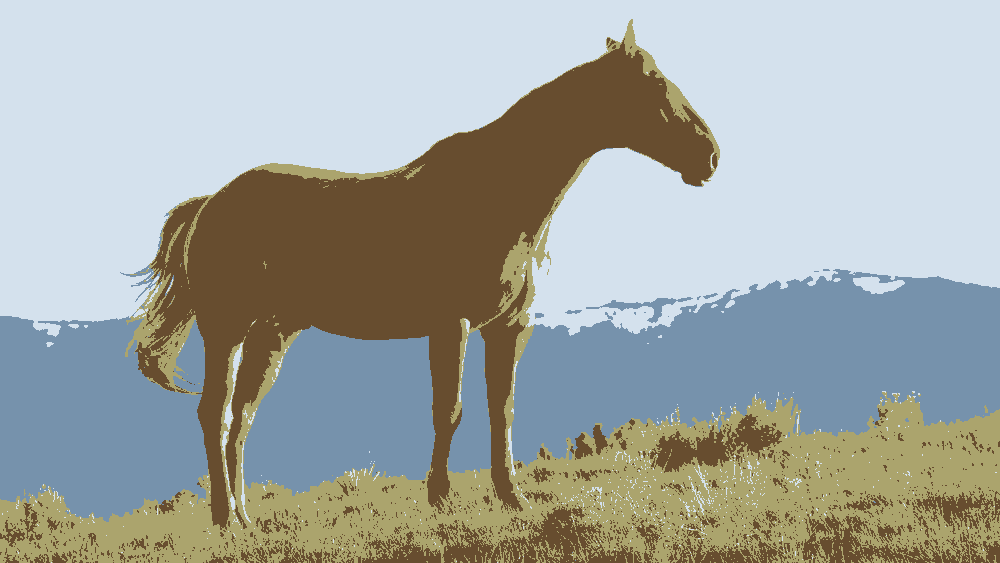

In [45]:
print("4 clusters:")
I.fromarray(kmeaner(df,clusters=4).astype('uint8'))

5 clusters:


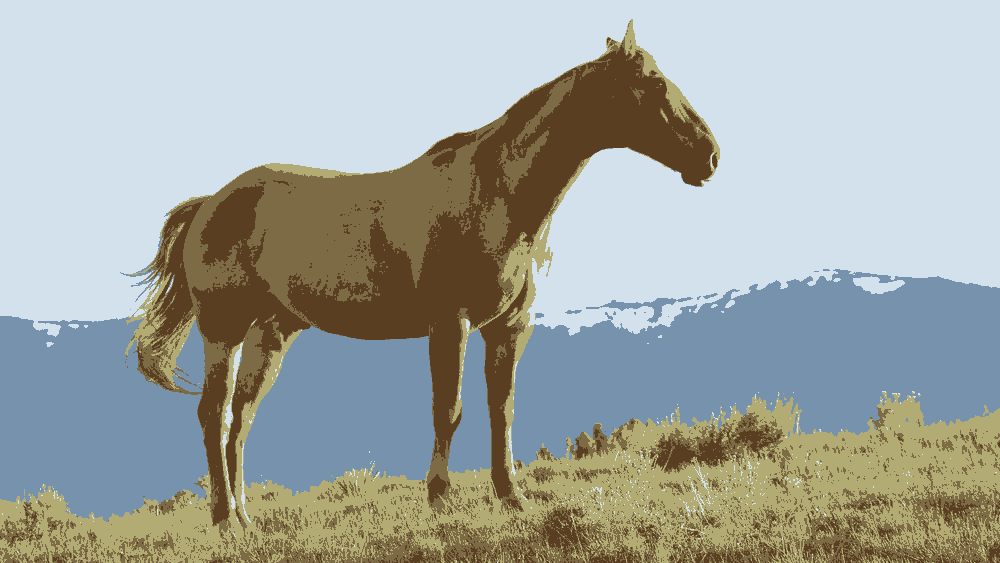

In [46]:
print("5 clusters:")
I.fromarray(kmeaner(df,clusters=5).astype('uint8'))

Notice how the difference between the images as cluster number goes up starts to diminish. After k=3, the image looks very similar in terms of present details, and the addition of another cluster simply allowed more variety in color. Then, from k=4 to k=5, more defined and specific details come through, in which there were more subtle differences in image tone.

# Part J - Prewitt and Sobel

Both Prewitt and Sobel operators serve to detect edges in an image via a kernel and convolution. To correctly run both methods, the image must be convoluted against the kernel AND the kernel's transform, to detect edges in both the horizontal and vertical directions. The prewitt differs from the sobel operator in terms of the values used in its kernel. 

### Prewitt Method

In [47]:
kernely = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
kernelx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])

x_t = cv2.filter2D(df_grey,-1,kernelx).astype(int)

y_t = cv2.filter2D(df_grey,-1,kernely).astype(int)

x-direction


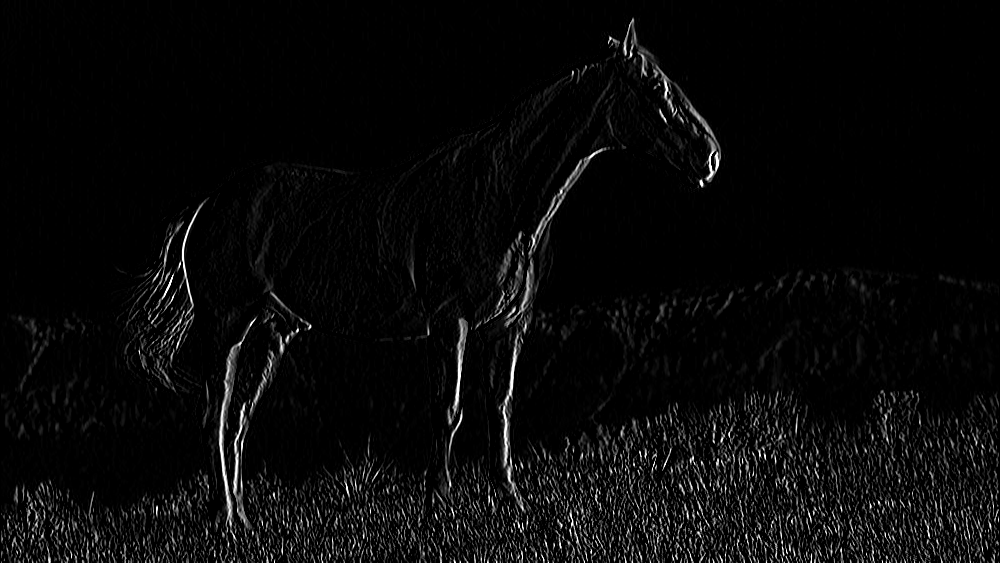

In [48]:
print("x-direction")
I.fromarray(x_t.astype('uint8'))

y-direction


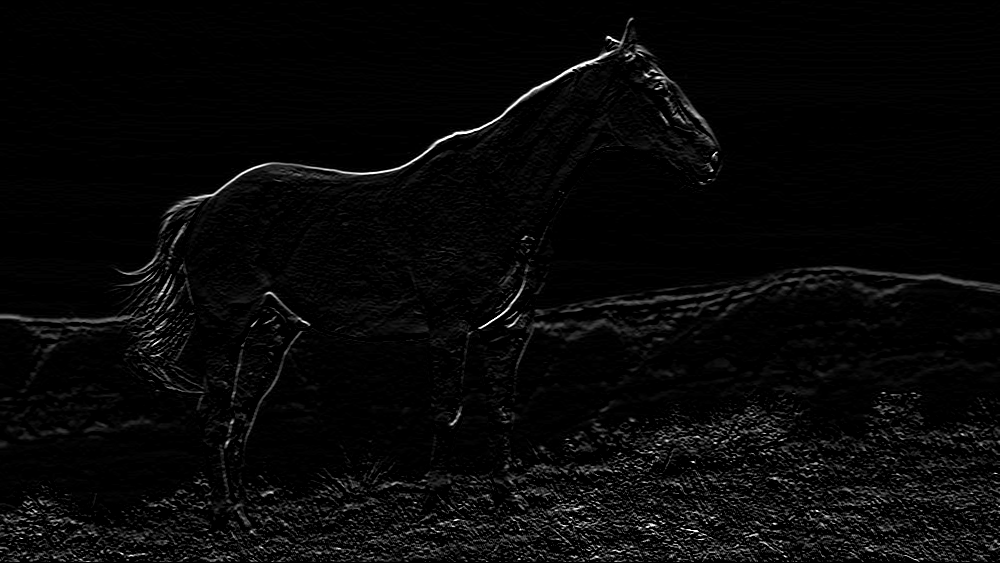

In [49]:
print("y-direction")
I.fromarray(y_t.astype('uint8'))

X-direction + Y-direction


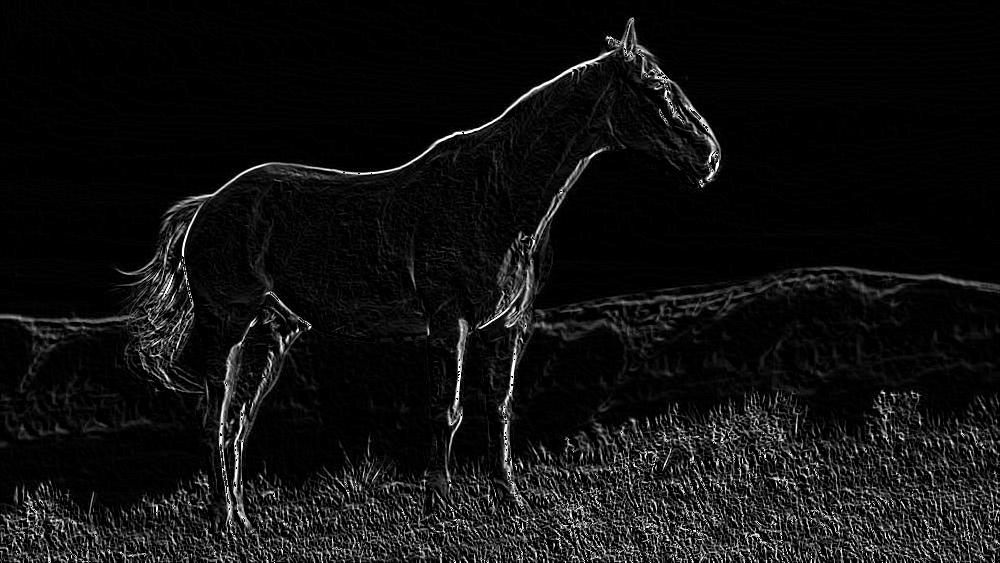

In [50]:
print("X-direction + Y-direction")
I.fromarray(x_t.astype('uint8') + y_t.astype('uint8'))

#### Different Thresholds with Prewitt

Threshold Applied: T = 100


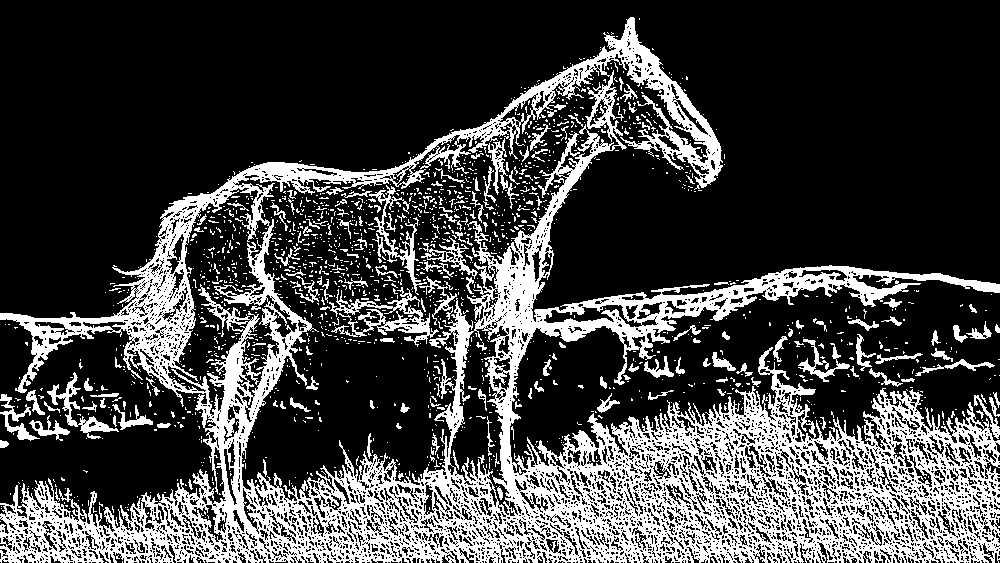

In [51]:
print("Threshold Applied: T = 100")
I.fromarray(np.where(x_t*x_t + y_t*y_t>100,255,0).astype('uint8'))

Threshold Applied: T = 500


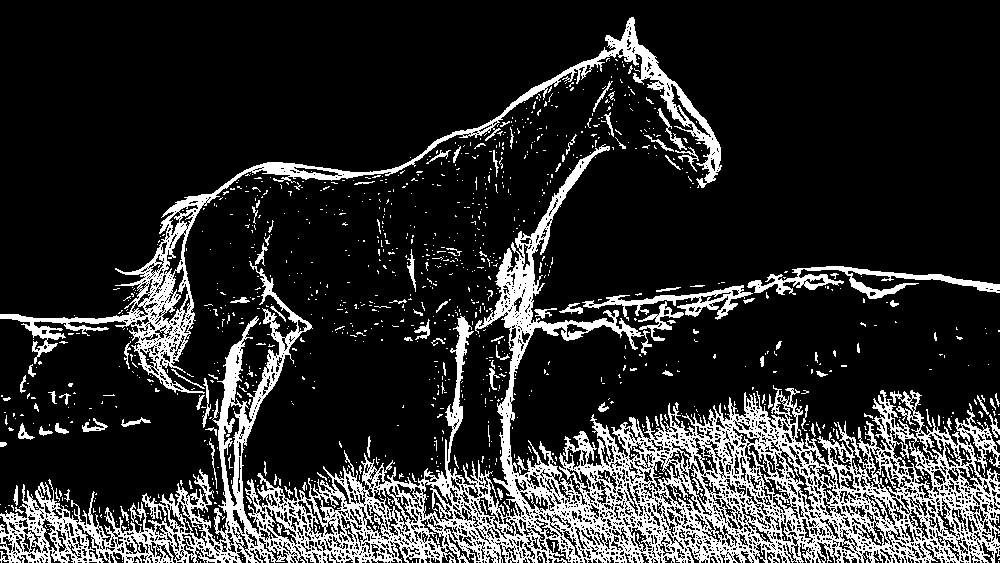

In [52]:
print("Threshold Applied: T = 500")
I.fromarray(np.where(x_t*x_t + y_t*y_t>500,255,0).astype('uint8'))

Threshold Applied: T = 1000


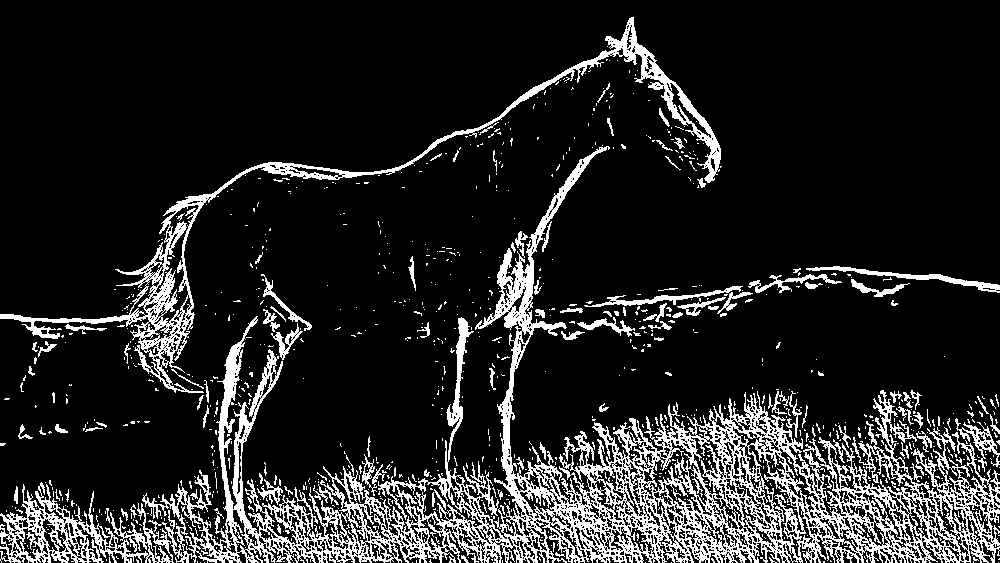

In [53]:
print("Threshold Applied: T = 1000")
I.fromarray(np.where(x_t*x_t + y_t*y_t>1000,255,0).astype('uint8'))

As can be seen, as expected, as the threshold increases, the lines become less noisy, and only more distinct, prominent edges are revealed. Prewitt seems to do a nice job defining the edges of the horse's face, its tail, the direction of the blades of grass, and the line separating the mountain and the sky in the background. When the threshold is low, there is a lot of noise due to catching "edges" between different levels of shading, which are not ideal. a threshold of 1000 seems perfect, except for not being well-able to capture the edge of the belly of the horse. 

### Sobel Method

With the sobel method, I run it with various threshold values, which can be seen below!

But first, I will set up my x and y kernels, and show the individual results of convolution with the x-kernel and the y-kernel, before showing the final detected edges with various thresholds.

In [54]:
x_kern = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
y_kern = x_kern.T

X-direction


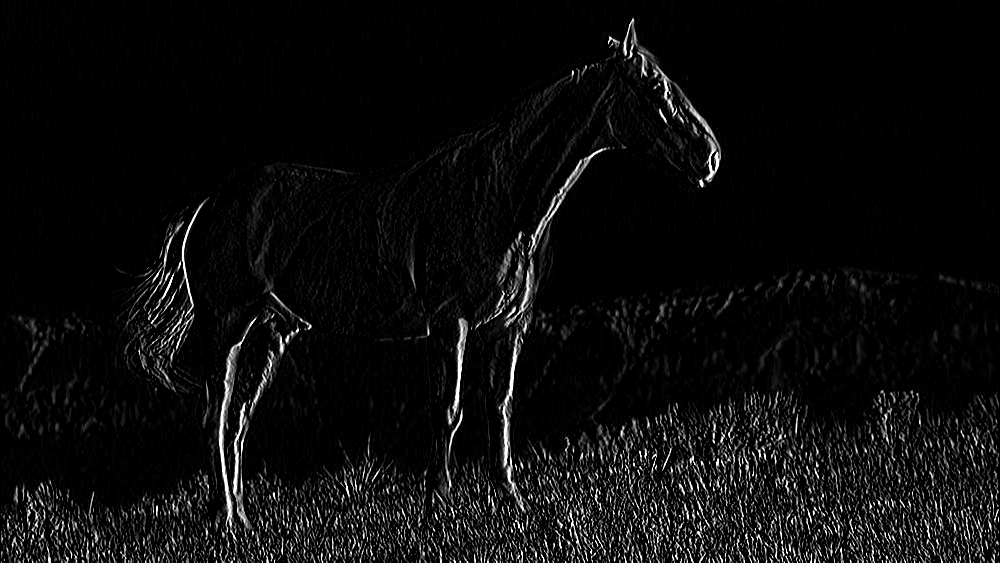

In [55]:
print("X-direction")
I.fromarray(cv2.filter2D(df_grey,-1,x_kern))

Y-direction


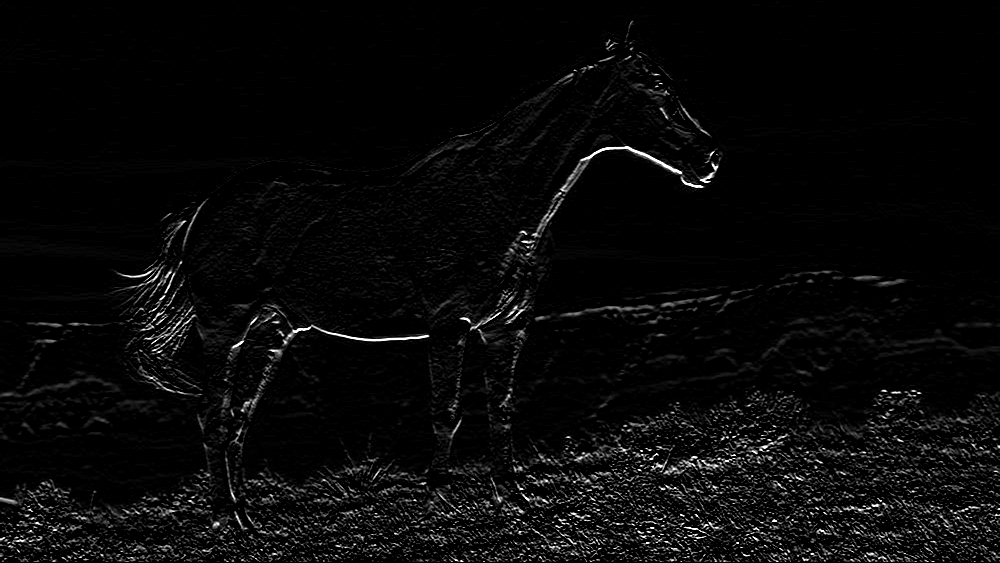

In [56]:
print("Y-direction")
I.fromarray(cv2.filter2D(df_grey,-1,y_kern))

X-direction + Y-direction


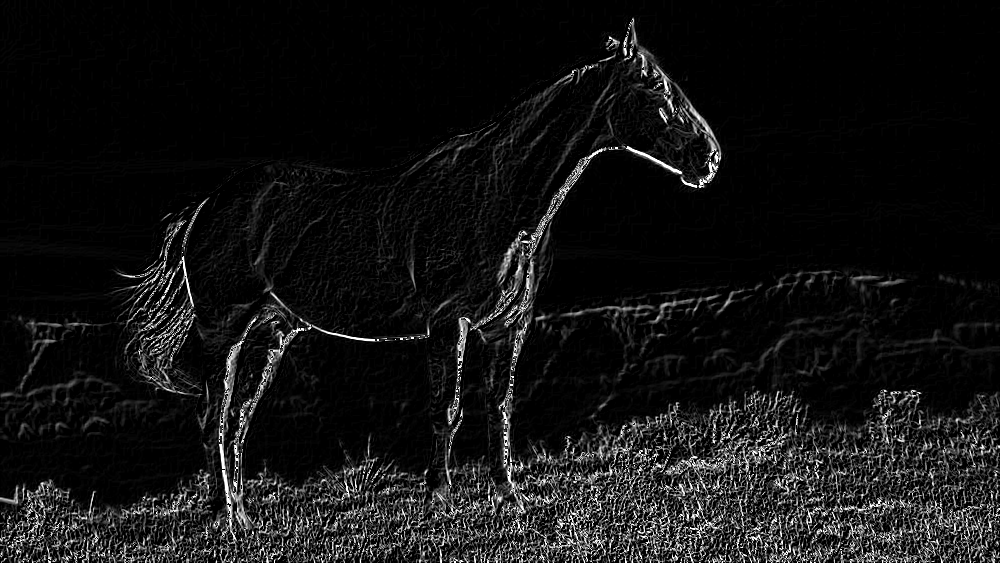

In [57]:
print("X-direction + Y-direction")
I.fromarray(cv2.filter2D(df_grey,-1,x_kern)+cv2.filter2D(df_grey,-1,y_kern))

#### Different Thresholds with Sobel

Threshold Applied: T = 100


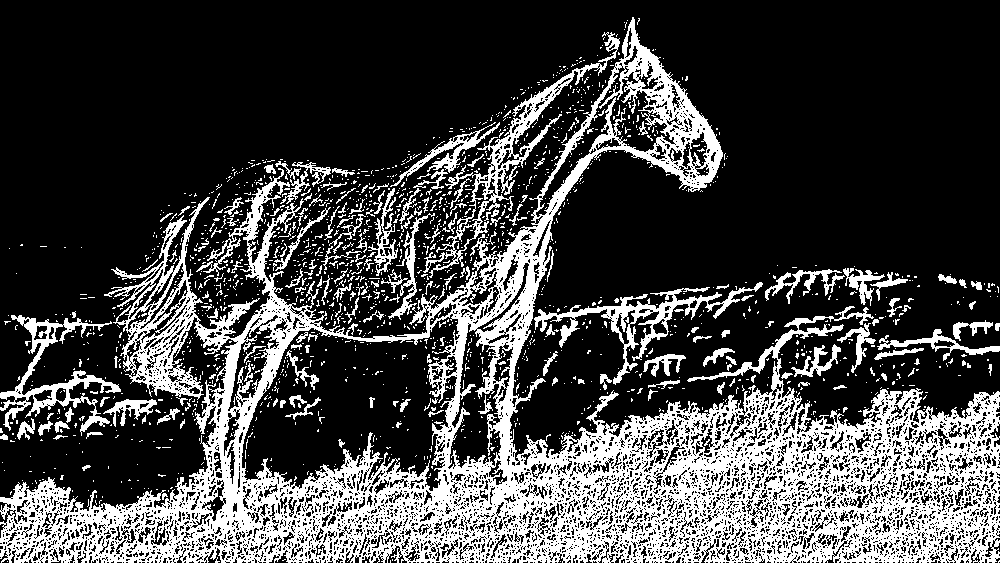

In [58]:
print("Threshold Applied: T = 100")
I.fromarray(np.where((cv2.filter2D(df_grey,-1,x_kern).astype(int)**2+cv2.filter2D(df_grey,-1,y_kern).astype(int)**2)>100,255,0).astype('uint8'))

Threshold Applied: T = 500


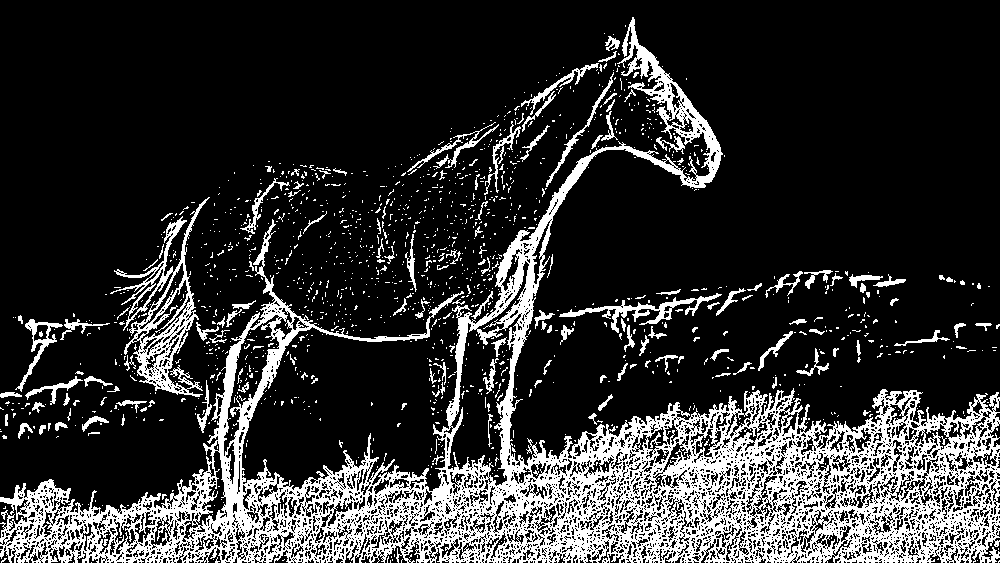

In [59]:
print("Threshold Applied: T = 500")
I.fromarray(np.where((cv2.filter2D(df_grey,-1,x_kern).astype(int)**2+cv2.filter2D(df_grey,-1,y_kern).astype(int)**2)>500,255,0).astype('uint8'))

Threshold Applied: T = 1000


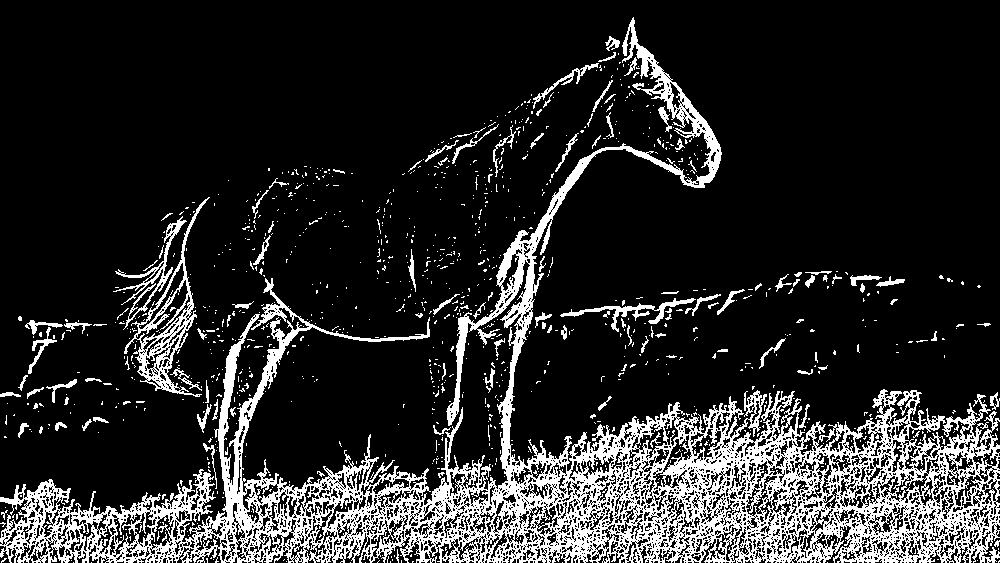

In [60]:
print("Threshold Applied: T = 1000")
I.fromarray(np.where((cv2.filter2D(df_grey,-1,x_kern).astype(int)**2+cv2.filter2D(df_grey,-1,y_kern).astype(int)**2)>1000,255,0).astype('uint8'))

As can be seen, when using thresholds on the final matrix "f", the lower the threshold, the more edges are detected, and the edges become more prominent. As can be seen when threshold is set to 1000, only the most obvious edges, or changes in value across 2D spaces of pixels, are detected. When the threshold is decreased to 500, nearly all of the horse, which forms the strongest lines in the photo, is detected, with an increasing amount of noise forming the body of the horse. As we decreaswe to a threshold of 100, a lot more fine details are detected, including simple shading on the horse's body, which might not be ideal. The horser is now very clearly defined, and parts of the mountain in the background are now also detected, but the shapes formed by the detected edges not resembling the true background much at all, but rather detecting more shifts in shades due to different colors in the original photo.

Notice too how this method has a better time at detecting the belly of the horse, but a harder time detecting the back, which seems the opposite of the Prewitt method. The Prewitt method also seemed to do better at detecting finer facial features, but Sobel does a good job at defining the tail in a less noisy way.